# A. Importance Sampling and Off-policy MCPG

## Off-policy Learning

Ch.19에서 사용한 알고리즘은 REINFORCE로, 아래와 같은
objective function와 gradient를 학습에 사용합니다.

$$
J(\theta) = \mathbf{E}_{\pi_\theta} [G_{s,a}]
$$
$$
\nabla_\theta J(\theta) = \mathbf{E}_{\pi_\theta}
[G_{s,a} \nabla_\theta \log \pi_\theta(s, a)]
$$

이 중 일부 경우만 샘플링하여 근사하기 때문에, 실제로
매 단계별로 사용하는 변화량은
$$
\Delta_\theta J(\theta) =
\sum_{(s,a) \text{ in episode}} G_{s,a} \nabla_\theta \log \pi_\theta(s, a)
$$
가 됩니다.

여기서 문제는 여기서 gradient가 $\pi_\theta$에 종속적인
기댓값이라는 것입니다.
다르게 말해서 다른 policy $\pi_\eta$를 따르는 agent가
임의의 플레이로 얻은 episode로 기댓값을 계산하면 $\pi_\theta$로
샘플링을 하였을 때는 다른 결과가 나올 수 있어 문제가 됩니다.

만약에 다른 agent나 자신의 지금까지 학습되기 전에 있었던
episode를 replay로 쓰기 위해서는 저 기댓값 차이 문제를
해결할 필요가 있습니다.

## Importance Sampling (중요 샘플링)

중요 샘플링은 서로 다른 확률분포 $p$, $q$를 알고 있고
함수 $f$가 있을 때,
$p$에 대한 $f$의 기댓값을 $p$ 대신 $q$를 따라 샘플링하여
계산하는 방법입니다.

$p$에 대한 $f$의 기댓값은
$$
\mathbf{E}_{X \sim p}[f(X)] = \int_\Omega p(x)f(x)dx
$$
인데, 이 적분 식에 $q(x)/q(x)$를 곱하여
$$
\int_\Omega p(x)f(x)dx = \int_\Omega q(x) \frac{p(x)}{q(x)}f(x) dx
= \mathbf{E}_{X \sim q}\left[\frac{p(x)}{q(x)}f(x)\right]
$$
이므로,
$$
\mathbf{E}_{X \sim p}[f(X)]
=
\mathbf{E}_{X \sim q}\left[\frac{p(x)}{q(x)}f(x)\right]
$$
라는 식을 얻을 수 있습니다.

따라서 $p$와 다른 $q$를 바탕으로 샘플링을 하였더라도,
$p/q$를 곱해서 기댓값을 계산하여 원래 분포의 기댓값을
구할 수 있습니다.

## Importance Sampling and Off-Policy

이제 원래 objective function의 gradient인
$$
\nabla_\theta J(\theta) =
\mathbf{E}_{(s,a) \sim \pi_\theta}
[G_{s,a} \nabla_\theta \log \pi_\theta(s, a)]
$$
에서 샘플링되는 $G_{s, a}$를 수정해야 하는데,
여기서는 오목처럼 episode 마지막인 $L$에 reward가 주어진다고 하면
$$
G_t = \sum_{k=t}^{L} \gamma^{k - t} R_k = \gamma^{L - t} R_L
$$
이며, importance sampling에 따라 분포의 비를 곱하게 되면
$$
G'_t =
\sum_{k=t}^{L} \gamma^{k - t} \left(
  \prod_{j=k}^{L} \frac{\pi_\theta(s_j, a_j)}{\pi_\eta(s_j, a_j)}
  \right)  R_k
= \gamma^{L - t} R_L \prod_{j=t}^{L} \frac{\pi_\theta(s_j, a_j)}{\pi_\eta(s_j, a_j)} 
$$
이라고 할 수 있으며, 이를 바탕으로
$$
\nabla_\theta J(\theta) =
\mathbf{E}_{(s,a) \sim \pi_\eta}
\left[
  G'_{s,a} \nabla_\theta \log \pi_\theta(s, a)
\right]
$$
로 바꿔 쓸 수 있습니다.

이제 이것을 바탕으로 off-policy learning을 하려면
replay 등 episode를 저장할 때 state $s$, action $a$,
reward $r$ 뿐만 아니라 각 action별로 $\pi_\eta(s, a)$
를 추가적으로 저장한 뒤 위와 같은 연산을 해주면 됩니다.

### Environment

In [1]:
!rm -rf mock5.py mock5 gen.cpp read_record.py gen
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.18 KiB | 4.46 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import os
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)

print("cudnn: {} (det {}; bench {})".format(
    torch.backends.cudnn.enabled,
    torch.backends.cudnn.deterministic,
    torch.backends.cudnn.benchmark))
print("OpenMP: {}".format(torch.backends.openmp.is_available()))

Device: cuda
cudnn: True (det False; bench True)
OpenMP: True


### Board Size

In [3]:
# Board Size
W = 15
H = W

### Agent & Policy Transformer

In [4]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)
  
def agent(pi):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

In [31]:
def agent_with_prob(pi):
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      dist = m / s
    else: dist = p / s
    idx = np.random.choice(h * w, p=dist)
    return idx, dist[idx]
  return c

def agent_mixed_with_prob(game):
  a = np.random.uniform()
  if a < 0.4: r, c = m5aa.agent(game)
  elif a < 0.8: r, c = m5ad.agent(game)
  elif a < 0.9: r, c = m5pt.agent(game)
  else: r, c = m5df.agent(game)
  return r * game.width + c, 1.0

In [6]:
def test_agents(num_game, agent1, agent2):
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    result = g.play(agent1, agent2,
                    print_intermediate_state=False, print_messages=False)
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  print("-- Test Result --")
  print("* Agent1 = {} \n* Agent2 = {}".format(
      fn_name(agent1), fn_name(agent2)))
  print("Total : {:5d}".format(num_game))
  print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
  print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))

### Stat Record

In [11]:
class Stat:
  def __init__(self, n=0, w=0, l=0, d=0): self.n, self.w, self.l, self.d = n, w, l, d
  def dup(self):
    return Stat(self.n, self.w, self.l, self.d)
  def __sub__(self, other):
    return Stat(self.n - other.n, self.w - other.w, self.l - other.l, self.d - other.d)
  def __str__(self):
    return "{:8.4f}% ({}w + {}d + {}l = {})".format(
            100 * self.win_rate(), self.w, self.d, self.l, self.n)
  def win(self):
    self.n += 1
    self.w += 1
  def lose(self):
    self.n += 1
    self.l += 1
  def draw(self):
    self.n += 1
    self.d += 1
  def update_by_result(self, result):
    self.n += 1
    if result == 1: self.w += 1
    elif result > 1: self.l += 1
    else: self.d += 1
  def win_rate(self):
    if self.n >= 1: return (self.w + 0.5 * self.d) / self.n
    else: return np.nan

### Neural Network


In [7]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class Block1(nn.Module):
  def __init__(self, ch, int_ch, ker):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(ch, int_ch, ker, padding='same'),
      nn.GELU(),
      nn.Conv2d(int_ch, ch, ker, padding='same'))
  def forward(self, x):
    y_0 = self.seq(x)
    return nn.functional.gelu(x + y_0)

class Policy(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(2, 128, 3, padding='same'),
      nn.GELU(),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      nn.Conv2d(128, 1, 5, padding='same'),
      nn.GELU(),
      # Flatten
      Flatten(),
      # Softmax
      nn.LogSoftmax(dim=-1))

  def forward(self, x):
    return self.seq(x)

In [8]:
def game_to_tensor(game):
  t = torch.zeros(2, game.height * game.width, dtype=torch.float)
  for i in range(game.height * game.width):
    b = game.board[i]
    if b == game.player: t[0][i] = 1.0
    elif b != 0: t[1][i] = 1.0
  return t.view(2, game.height, game.width)

In [9]:
def policy_model(net):
  def c(game):
    X = game_to_tensor(game).to(device)
    with torch.no_grad():
      p = torch.exp(net(X))
    arr = p.squeeze().to('cpu').numpy()
    return arr
  c.name = 'model({:x})'.format(id(net))
  return c

### Episode & Replay

여기서는 replay에 episode를 저장해둔 뒤, 학습 시
꺼내서 사용할 것입니다.

아래 `loss`를 보면 importance sampling weight를
계산하는 것을 확인할 수 있습니다.

In [104]:
class Episode:
  def __init__(self, game, winner, probs):
    self.game = game
    self.L = len(game.history)
    w = [1, 0] if winner == 1 else [0, 1] if winner == 2 else [0.5, 0.5]
    self.R = torch.tensor([w[i % 2] for i in range(self.L)], dtype=torch.float)
    self.A = torch.tensor(game.history, dtype=torch.long).unsqueeze(dim=0)
    self.Q = torch.tensor(probs, dtype=torch.float)
    Xs = [None] * self.L
    game = game.replay()
    while len(game.history) > 0:
      game.undo()
      Xs[len(game.history)] = game_to_tensor(game)
    self.X = torch.stack(Xs)
  
  def loss(self, policy):
    log_pi = policy(self.X.to(device))
    log_P = log_pi.gather(1, self.A.to(device)).squeeze()
    PQ = torch.exp(log_P.cpu().detach()) / self.Q
    for i in range(self.L - 3, 0, -1):
      PQ[i] *= PQ[i + 2]
    R = self.R * PQ
    loss = - R.to(device) * log_P
    return loss.mean()

In [24]:
from collections import deque

class Replay:
  def __init__(self, size):
    self.size = size
    self.episodes = deque(maxlen=size)

  def __len__(self):
    return len(self.episodes)

  def __getitem__(self, key):
    return self.episodes[key]
  
  def append(self, ep):
    self.episodes.append(ep)

  def choose(self):
    l = len(self.episodes)
    if l <= 0: return None
    i = np.random.randint(l)
    return self.episodes[i]

In [33]:
def gen_episode_by_play(
    replay,
    agent_w1,
    agent_w2
):
  probs = []
  game = Mock5(H, W)
  t = np.random.randint(2)
  for i in range(H * W):
    result = game.check_win()
    if result is not None: break
    a, p = [agent_w1, agent_w2][(t + i) % 2](game)
    probs.append(p)
    game.place_stone_at_index(a)
  if result is None: result = game.check_win()
  for f in range(2):
    for r in range(4):
      replay.append(Episode(game.replay(flip=f, angle=r), result, probs))
  if result != 0 and t == 1: result = 3 - result
  return result

In [96]:
# REINFORCE
def learn(
    policy,
    agent_w1, # If None, use policy
    agent_w2,
    opt,
    n_episode,
    n_epoch,
    interval_stat
):
  if agent_w1 is None:
    stat = Stat()
    last_stat = stat.dup()
    agent_w1 = agent_with_prob(policy_model(policy))
  else:
    stat = None
  last_stat_epi = -1
  loss_avg = 0
  for epi in range(n_episode):
    # Generate episode
    result = gen_episode_by_play(replay, agent_w1, agent_w2)
    if stat is not None: stat.update_by_result(result)
    # Learn
    for e in range(n_epoch):
      opt.zero_grad(set_to_none=True)
      loss = replay.choose().loss(policy)
      loss.backward()
      opt.step()
      loss_avg += loss.item() / n_epoch
    # Print status and evaluate
    if epi - last_stat_epi >= interval_stat:
      print("----------")
      print("Ep #{:<6d} Loss {:13.10f}".format(epi + 1, loss_avg / interval_stat))
      if stat is not None:
        print("  Win Rate {})".format(str(stat)))
        print("   WR Diff {})".format(str(stat - last_stat)))
        last_stat = stat.dup()
        print(replay[len(replay) - 1].game)
      else:
        test_a = agent(policy_model(policy))
        test_agents(10, test_a, m5pt.agent)
      last_stat_epi = epi
      loss_avg = 0

### Learning

In [82]:
u = torch.load('19_weight_10hr')
p19_nn = Policy()
p19_nn.load_state_dict(u['network state dict'])
p19_nn = policy_nn.to(device)

 [ Turn  24 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . .
4 | . . O . O O O . . . . . . . .
5 | . . X X X X X O . . . . . . .
6 | . . . . X . O X . . . . . . .
7 | . . O X X X . O X . . . . . .
8 | . . . . . . X O O O . . . . .
9 | . . . . . . . O . . . . . . .
A | . . . . . . . . . . . . . . .
B | . . . . . . . . . . . . . . .
C | . . . . . . . . . . . . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
2p (stochastic(model(7ff02a654810))) win!


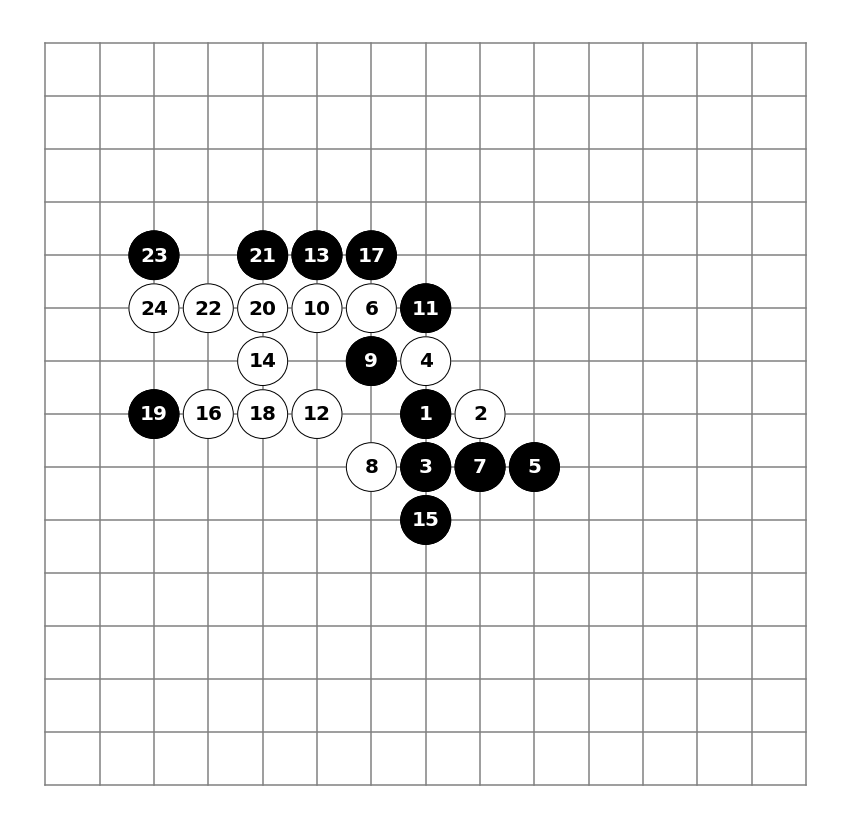

In [83]:
m = Mock5(H, W)
m.play(agent(policy_model(p19_nn)), m5ad.agent,
  print_intermediate_state=False)
m.plot()
plt.show()
plt.close()

In [107]:
replay = Replay(1024)
policy_nn = Policy().to(device)

opt = optim.SGD(policy_nn.parameters(),
                lr=1e-1,
                momentum=0.8,
                weight_decay=1e-6)

agent_w2 = agent_mixed_with_prob

learn(
    policy = policy_nn,
    agent_w1 = agent_with_prob(policy_model(p19_nn)), # Use policy
    agent_w2 = agent_w2,
    opt = opt,
    n_episode = 5000,
    n_epoch = 20,
    interval_stat = 100)

----------
Ep #100    Loss  0.0045499386
-- Test Result --
* Agent1 = stochastic(model(7ff02aac4b90)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   11.5)
----------
Ep #200    Loss  0.0033233936
-- Test Result --
* Agent1 = stochastic(model(7ff02aac4b90)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   13.0)
----------
Ep #300    Loss  0.0052552101
-- Test Result --
* Agent1 = stochastic(model(7ff02aac4b90)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   13.1)
----------
Ep #400    Loss  0.0057689743
-- Test Result --
* Agent1 = stochastic(model(7ff02aac4b90)) 
* Agent2 = agent-pt
Total :    10
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    10 (1.000) (avg.mov   13.8)
----------
Ep #500    Loss  0.0004345284
-- Test Result --
* Agent1 = stochastic(model(7ff02aac4b90)) 
* Agent2 = agent-pt
Total :    10
A1 

위는 이전에 학습했던 `19_weight_10hr`이 실행한 플레이를
바탕으로
학습이 전혀 안 됨 neural network를 약 30분간 학습시킵니다.

생각보다 학습이 잘 안 되는 것을 확인할 수 있는데,
가장 큰 이유로는 신경망이 처음에는 거의 uniform하게 초기화가
되어 있기 때문에, 각 수를 선택할 확률이 약
$\frac{1}{225} \simeq 0.44 \%$로 매우 낮습니다.
때문에 $\frac{p}{q} = \frac{0.0044}{q}$
와 같이 importance sampling weight가 기존의 weight인
$1$에 비해 매우 작아지고, 이 때문에 학습이 매우 더뎌지게 됩니다.

만약에 가능한 action space가 넓은 경우에는 처음에
importance sampling weight가 너무 낮아지지 않도록
clipping을 하는 것이 좋을 것 같습니다.